**After this laboratory you should be able to**
- Explain the task of **Node-classification**
- Explain the **Classifier framework**
- Understand the techniques provided

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os, sys
import random
from tqdm import tqdm

from sklearn.metrics import accuracy_score

In [27]:
parent_dir = os.path.abspath(os.path.join('..'))
if not parent_dir in sys.path:
    sys.path.append(parent_dir)
    
from utils.utils import average_clustering, average_degree, connectivity_perc, giant_component, print_stats, GraphReader

## Utils

# Node clasification

**Task**  
We are given a graph where some of the nodes have labels(categorical, numerical, binary) and some don't. Our task is to label the remaining nodes.

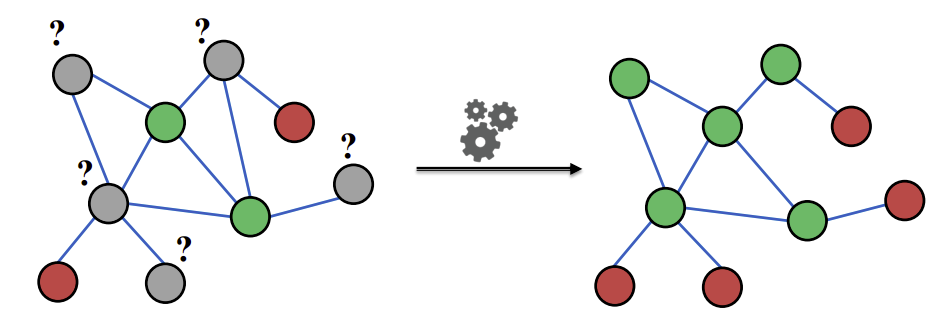

**Assumption about the data:** Similar nodes (with similar label) are connected. We want to exploit this fact.

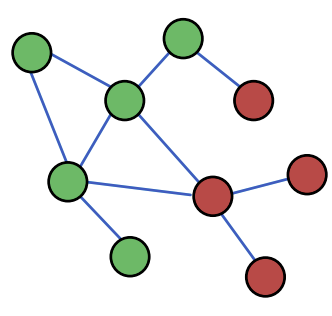

We encounter 2 phenomena:
1. **Homophily**  
    Nodes (individuals) that have similar characteristics are connected and probably have the same label -- *birds of the same feather flock together*. Ex: Researchers who focus on the same area tend to make friendships
2. **Influence**  
    Social connections influence the individual characteristics. Ex: I recommend my musical preferences to my friends -> they might like it
    
**What do we look at when we classify?**
- The node's features
- The neighbours labels
- The neighbours features

**Techniques**
1. Relational classification
2. Iterative classification
3. Belief propagation

## Classifier framework

**Local classifier** -- Assign initial labels
- Predicts labels based on node attributes / festures
- Does not use network information

**Relational classifier** -- Capture correlations between nodes
- Learns a classifier to label one node based on label / features of the neighbours
- Uses network information

**Collective inference** -- Propagate the correlation
- Apply relational classifier to each node itaretively
- Iterate until the inconsistency between neighboring labels is minimized


Workflow
1. The **local classifier** is applied once at the beginning
2. Apply the **relational classifier** and **collective inference** iteratively for a number of steps or until a stopping condition

## Relational classifier

*Intuition*: Weighted average of the neighbours labels. 

This classifier will only look at the nodes labels. We are not going to use the attributes.

**Classifier**  
Consider the task of binary classification. We are given a graph $G$ and some of the nodes are labeled
1. Initialization
    - for labeled nodes $v$ let $Y_v \in \{0, 1\}$ be the label. For unlabeled nodes we initalize their label with a uniform value (0.5)
2. Update rule
    $$P(Y_v = c) = \dfrac 1 {\sum_{(v, u) \in E}A_{v,u}}\sum_{(v,u) \in E}A_{v,u}P(Y_u = c)$$
    where 
    - $A$ is the weight matrix. For an unweighted graph this is the adjacency matrix 
    - $P(Y_v = c)$ -- Probability that node $v$ has label $c$
    - $\sum_{(v, u) \in E}A_{v,u}$ -- Sum of neighbour edge weights. For unweighted graph this is the node degree / in-degree. This is a normalizing factor
    - $\sum_{(v,u) \in E}A_{v,u}P(Y_u = c)$ -- Sum the edge weight to the neighbour node $u$ times the probability of that node being in class $c$
    
**Problems**
- Convergence is not guaranteed
- Model cannot use node feature information

### Run one iteration

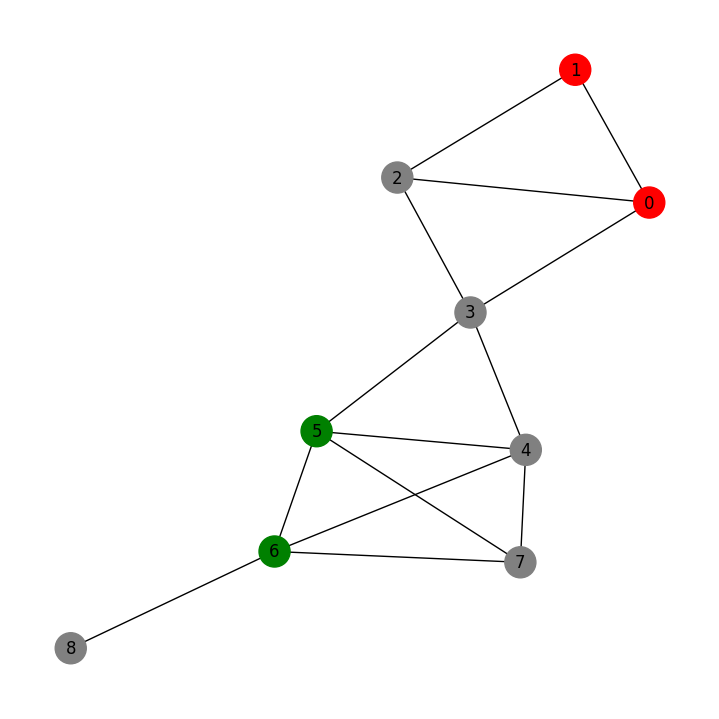

In [28]:
edges = [(0, 1), (0, 2), (0, 3), (1, 2), (2, 3), (3, 4), (3, 5), (4, 5), (4, 6), (4, 7), (5, 7), (5, 6), (6, 7), (6, 8)]
G = nx.Graph(edges)

nodes_train = [0, 1, 5, 6]
nodes_test = [u for u in G.nodes if u not in nodes_train]
y_train = [0, 0, 1, 1]

node_color = ['grey'] * G.number_of_nodes()
for v, yv in zip(nodes_train, y_train):
    if yv == 0:
        node_color[v] = 'red'
    else:
        node_color[v] = 'green'

plt.figure(figsize = (7, 7))
nx.draw_kamada_kawai(G, with_labels=True, node_color = node_color, node_size = 500)


In [29]:
# def init_probs(G, nodes_train, y_train):
#     """
#     Initialize probabilities. 0.5 for unknown nodes and 0, 1 for the 2 given classes
#     """
    
#     assert(len(np.unique(y_train)) == 2), "Training labels must have 2 values"
#     probs = [0.5] * G.number_of_nodes()
#     for i, (v, yv) in enumerate(zip(nodes_train, y_train)):
#         probs[v] = yv
#     return probs
    
    
def init_probs(G, nodes, y):
    """
    Initialize probabilities. 0.5 for unknown nodes and {0, 1} for the 2 given classes
    Args:
        G: nx.Graph
            Given graph
        nodes: iterable
            iterable of training nodes
        y: iterable
            classes in {0, 1}
    Returns:
        :np.ndarray 
            initial nodes probabilities to be of class 0 or 1
    """
    assert(len(np.unique(y)) == 2), "Training labels must have 2 values."
    assert(len(nodes) == len(y)), "Length of training nodes and labels must be the same."
    probs = np.full(shape =  G.number_of_nodes(), fill_value = 0.5)
    probs[nodes] = y
    return probs

In [30]:
probs = init_probs(G, nodes_train, y_train)
print(probs)

[0.  0.  0.5 0.5 0.5 1.  1.  0.5 0.5]


In [31]:
def update(G, nodes_train, probs):
    probs = probs.copy()
    G_nodes = np.array(G.nodes)
    converged = nodes_train
    not_converged = np.array([v for v in G_nodes if v not in converged])    
    # For each node v that doesn't have a class
    # collect the probability from the neighbours and average it
    for v in not_converged:
        #probs[v] = 1 / G.degree(v) * sum(probs[u] for u in G.neighbors(v))
        probs[v] = np.mean([probs[u] for u in G.neighbors(v)])
    return probs


In [32]:
probs_ = update(G, nodes_train, probs)
print(probs_)

[0.         0.         0.16666667 0.41666667 0.72916667 1.
 1.         0.90972222 1.        ]


### Binary Relational Classifier model

In [33]:
class BinaryRelationalClassifier:
    def __init__(self, tol: float = .01):
        """
        Binary relational classifier
        
        Arguments
            tol: float = .01 
                Convergence tolerance. If the future label probability didn't change with at least `tol` 
                then the node converged
        """
        self.converged = []
        self.tol = tol
        self.probs = []
    
    def init_probs(self, G: nx.Graph, nodes_train: list, y_train: list):
        """
        Computes inital probabilities. Assigns 1 and 0 to labelled nodes and .5 to unlabelled ones
        
        Arguments:
            G: nx.Graph
                Undirected graph
            nodes_train: list
                List of training nodes from the graph G
            y_train: list
                List of training labels. All labels must be in [0, 1]
            
        Returns
            probs: list
                List of inital probabilities
        """
        self.converged = nodes_train.copy()
        probs = [0.5] * G.number_of_nodes()
        for i, (v, yv) in enumerate(zip(nodes_train, y_train)):
            probs[v] = float(yv)
        self.probs = probs
    
    def update(self, G):
        """
        Update step. Computes the future probabilities and marks convergent nodes
        """
        probs = self.probs
        future_probs = probs.copy()
        for v in G.nodes:
            if v not in self.converged:
                future_probs[v] = 1 / G.degree(v) * sum(probs[u] for u in G.neighbors(v))
                
                # Mark convergent if 
                if abs(future_probs[v] - probs[v]) < self.tol:
                    self.converged.append(v)
        self.probs = future_probs
    
    
    
    def fit(self, graph, nodes_train, y_train, steps = 10):
        """
        Fits a classifier on a graph
        
        Arguments
            graph: nx.Graph
                Undirected graph
            nodes_train: list
                List of training nodes from the graph G
            y_train: list
                List of training labels. All labels must be in [0, 1]
                
        Results:
            :BinaryClassificationModel -- Returns the model
        """
        G = graph.copy()
        assert len(nodes_train) == len(y_train), "Number of labels must be the same as number of training nodes"
        assert all(yv in [0, 1] for yv in y_train), "Labels must be in [0, 1]"
        assert all(u in G.nodes for u in nodes_train), "Nodes must be in the given graph"
        
        # Get starting probs
        self.init_probs(G, nodes_train, y_train)
        # Update
        for step in range(steps):
            if len(self.converged) == G.number_of_nodes(): # Break if we reach convergence
                break
            self.update(G)
            
        return self
    
    def predict(self, G, nodes_test):
        """
        Return predicted labels of nodes_test
        """
        assert all(u in G.nodes for u in nodes_test), "Nodes must be in the given graph"
        return [round(self.probs[v]) for v in nodes_test]
    
    def predict_proba(self, G, nodes_test):
        """
        Return predicted probabilities of nodes_test
        """
        assert all(u in G.nodes for u in nodes_test), "Nodes must be in the given graph"
        return [self.probs[v] for v in nodes_test]
        

In [34]:
model = BinaryRelationalClassifier()
model.fit(G, nodes_train, y_train)
preds = model.predict(G, G.nodes)

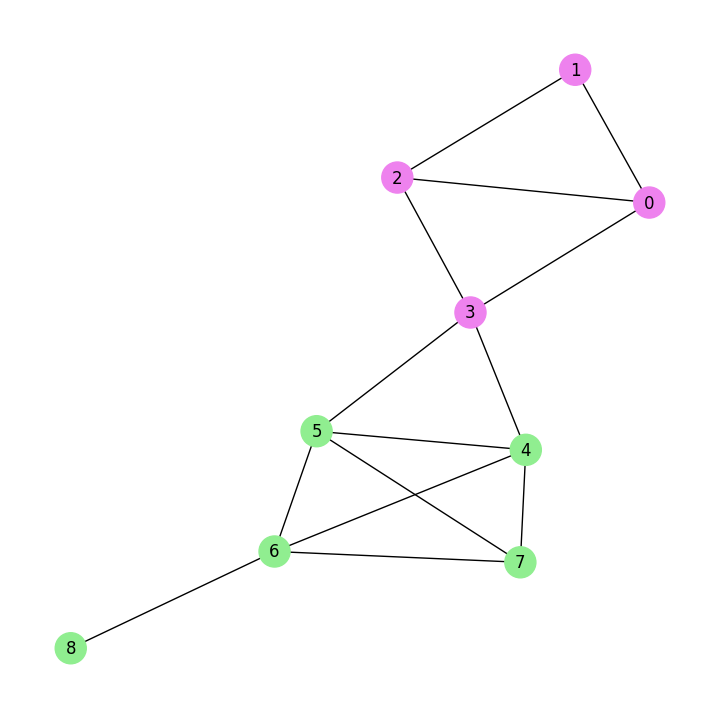

In [35]:
node_color = [''] * G.number_of_nodes()
for v, yv in zip(G.nodes, preds):
    if yv == 0:
        node_color[v] = 'violet'
    else:
        node_color[v] = 'lightgreen'

plt.figure(figsize = (7, 7))
nx.draw_kamada_kawai(G, with_labels=True, node_color = node_color, node_size = 500)

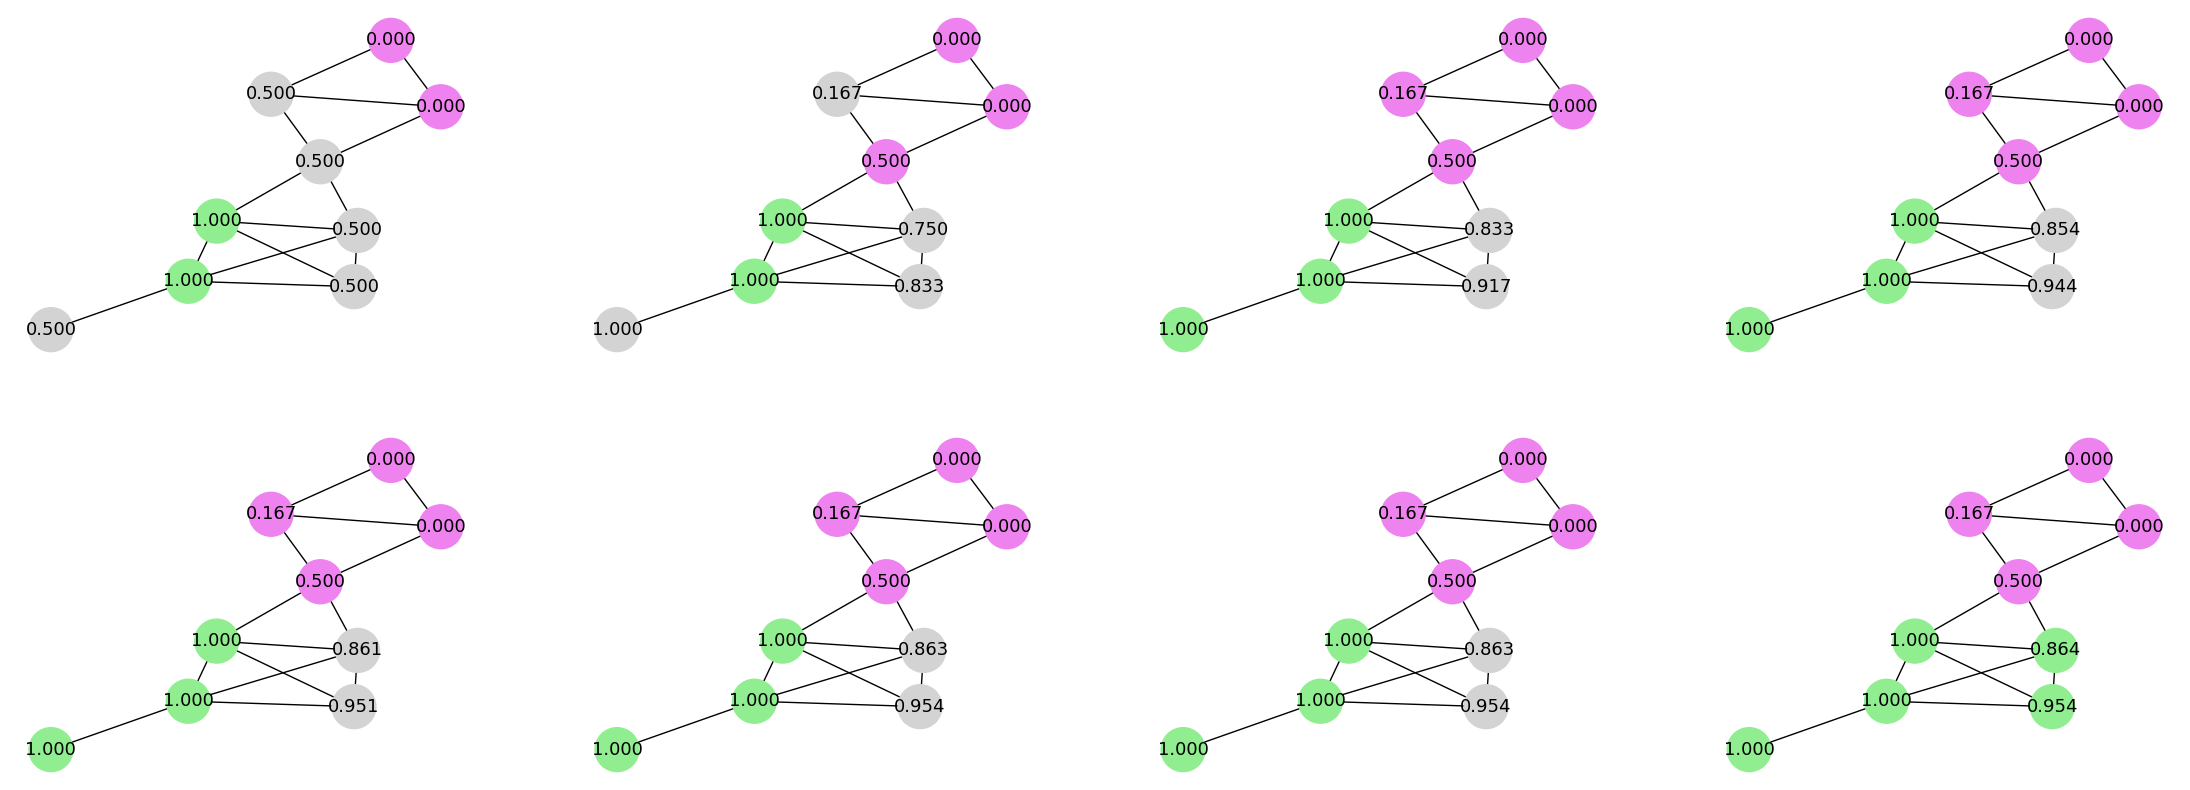

In [36]:
# Step by step

model = BinaryRelationalClassifier(tol = .0005)
model.init_probs(G, nodes_train, y_train)

steps = 8
plt.figure(figsize = (7 * 4, 10))

for step in range(steps):
    
    converged_nodes = model.converged
    converged_labels = model.predict(G, converged_nodes)
    
    node_color = ['lightgrey'] * G.number_of_nodes()
    for v, yv in zip(converged_nodes, converged_labels):
        if yv == 0:
            node_color[v] = 'violet'
        else:
            node_color[v] = 'lightgreen'
    
    nodeplt_labels = {u: f"{p:.3f}" for u, p in zip(G.nodes, model.predict_proba(G, G.nodes))}
    
    model.update(G)
    
    plt.subplot(2, 4, step+1)
    nx.draw_kamada_kawai(G, with_labels=True, labels = nodeplt_labels, node_color = node_color, node_size = 1000, font_size = 13)
    


### Real dataset

#### Karate club

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [38]:
G_karate = nx.karate_club_graph()

In [39]:
# Get classes
nodes = np.array(G_karate.nodes)
y = LabelEncoder().fit_transform(np.array(list(nx.get_node_attributes(G_karate, "club").values())))
print(y)

nodes_train, nodes_test, y_train, y_test = train_test_split(nodes, y, test_size=.8, random_state=42)

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1]


In [40]:
print(nodes_train)
print(nodes_test)


[20 33  7 10 14 28]
[15 19 27 26  8 24 21 12 32  9  0  4 16 17  5 13 11  1  2 30  3 29 23 31
 22 18 25  6]


In [41]:
model = BinaryRelationalClassifier()
model.fit(G_karate, list(nodes_train), list(y_train))

In [42]:
preds = model.predict(G_karate, nodes_test)
print(accuracy_score(y_test, preds))

0.8214285714285714


#### Twitch

In [43]:
name = "twitch" #  "wikipedia"
G = GraphReader(name).get_graph()
X = GraphReader(name).get_features()
y = GraphReader(name).get_target()

print(np.unique(y, return_counts=True))

(array([0, 1]), array([3238, 3888]))


In [44]:
print_stats(G, 100)

G.number_of_nodes() = 7126
G.number_of_edges() = 35324
average_degree(G) = 9.91
average_clustering(G) = 0.1309
connectivity_perc(G) = 1.00
average_shortest_path_length_sampled(G, n_samples) = 4.0


In [45]:
nodes = np.array(G.nodes)
nodes_train, nodes_test, y_train, y_test = train_test_split(nodes, y, test_size=.8, random_state=42)

In [46]:
model = BinaryRelationalClassifier()
model.fit(G, list(nodes_train), list(y_train))

In [47]:
len(model.converged) == len(G)

True

In [48]:
preds = model.predict(G, nodes_train)
print(accuracy_score(y_train, preds))


1.0


In [49]:
preds = model.predict(G, nodes_test)
print(accuracy_score(y_test, preds))

0.4897386423434485


## Iterative classification

*Intuition*: We want to use node attributes too. We will classify note $v$ based on attributes $x_v$ as well as the labels of the neighbours of $v$ encoded in $z_v$. Therefore we will use 2 classifiers.

Input: Graph
- with feature vectors for nodes
- some of the nodes are labeled

**Task**: We want to predict unlabeled nodes

**Classifier 1**  $\phi_1(x_v)$ -- Predicts $v$'s label based on the feature vector $x_v$
- Can be a linear classifier, nn, svm, random forest etc

**Classifier 2**  $\phi_2(x_v, z_v)$ -- Predicts $v$'s label based on the feature vector $x_v$ and summary of $v$'s neighbours label $z_v$
- What can $z_v$ be? It can be whatever we want! A histogram of the each label in the neighbourhood, most common label in the neighbourhood, number of different labels etc

In [50]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler


In [51]:
## Generate some data

# l communities with k nodes each
num_communities = 3
num_nodes_per_community = 32
G = nx.planted_partition_graph(l = num_communities, k = num_nodes_per_community, p_in = 0.5, p_out = 0.1, seed=42)
colors = ['violet', 'lightgreen', 'lightblue', 'yellow']
node_color = [colors[v] for v in nx.get_node_attributes(G, 'block').values()]
y = np.array(list(nx.get_node_attributes(G, 'block').values()))

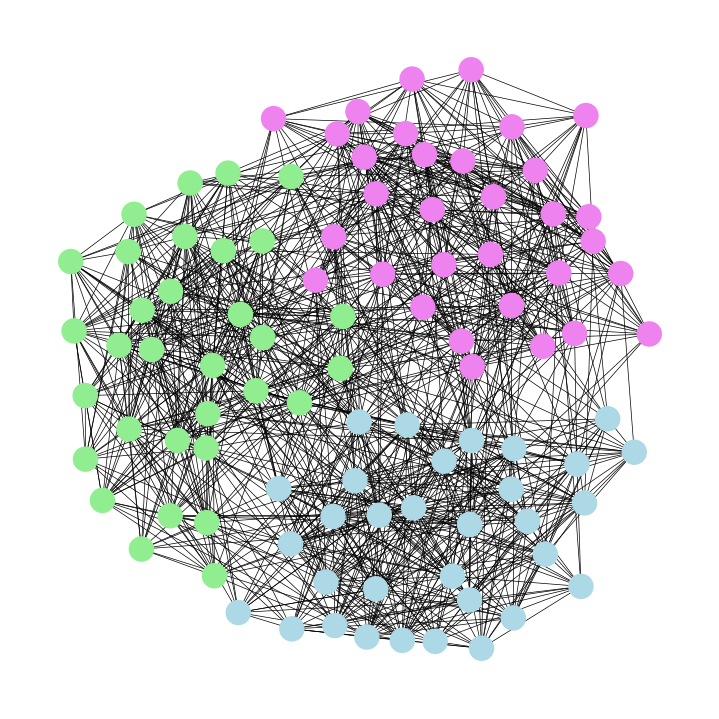

In [52]:
plt.figure(figsize = (7, 7))
nx.draw_kamada_kawai(G, node_color = node_color, width = .5)

In [53]:
## Generate some features

n_features = 10
X, y_ = make_classification(
    n_samples = num_communities * num_nodes_per_community,
    n_classes = num_communities,
    n_features = n_features,
    n_informative= n_features,
    n_redundant=0,
    n_clusters_per_class=1,
    shuffle=False
)
X = StandardScaler().fit_transform(X)

In [54]:
print(all(y == y_)) # make sure this is true
np.unique(y_, return_counts=True)

False


(array([0, 1, 2]), array([33, 32, 31]))

In [55]:
#plt.scatter(*X.T, c = node_color)

In [56]:
X_train, X_test, y_train, y_test, nodes_train, nodes_test = train_test_split(X, y, list(G.nodes), test_size=.8, random_state=42)

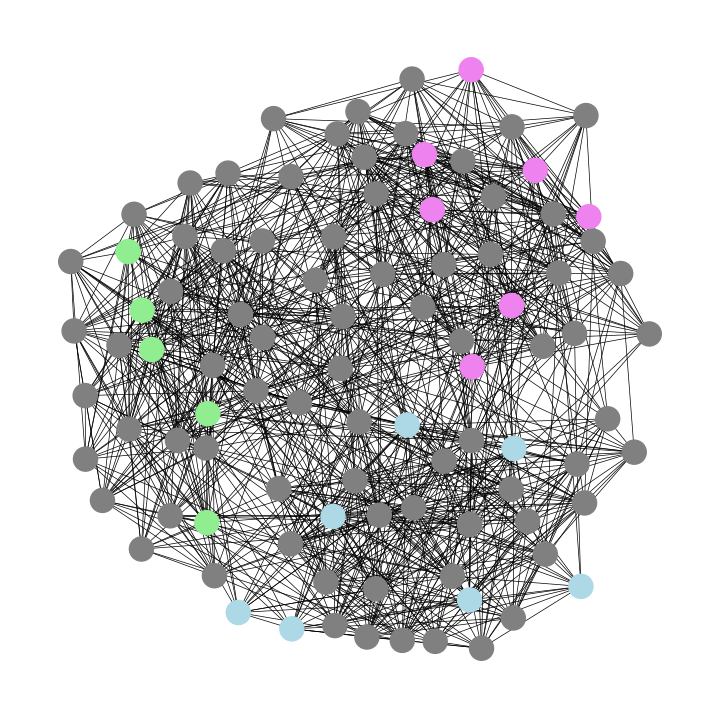

In [57]:
node_color = [colors[v] for v in nx.get_node_attributes(G, 'block').values()]
for v in nodes_test:
    node_color[v] = 'grey'
    
plt.figure(figsize = (7, 7))
nx.draw_kamada_kawai(G, node_color = node_color, width = .5)

### One step

In [58]:
phi1 = GradientBoostingClassifier()
phi1 = phi1.fit(X_train, y_train)

In [59]:
preds = phi1.predict(X_test)
accuracy_score(y_test, preds)

0.5714285714285714

In [60]:
def compute_zv(G, y):
    """
    Computes embedding features based on the graph labels
    """
    n_classes = len(np.unique(y))
    zvs = np.zeros((len(G), n_classes))
    # For each node v
    for v in G.nodes:      
        # Compute the histogram of its neighbours
        zv = np.zeros(n_classes)
        for u in G.neighbors(v):
            zv[y[u]]+=1 # Add the class of the neighbour to the histogram
        zvs[v] = zv / np.sum(zv)
    return zvs        

In [61]:
# Create a new array with the known labels `y_train` and the predicted ones `preds`
y_new = np.zeros(len(G.nodes), dtype=int)
y_new[nodes_train] = y_train 
y_new[nodes_test] = preds  
zvs = compute_zv(G, y_new)

In [62]:
X2 = np.concatenate([zvs, X], axis = 1)
X_train2 = X2[nodes_train]
X_test2 = X2[nodes_test]

In [63]:
phi2 = GradientBoostingClassifier()
phi2.fit(X_train2, y_train)

GradientBoostingClassifier()

In [64]:
preds2 = phi2.predict(X_test2)

In [65]:
accuracy_score(y_test, preds2)

0.922077922077922

### Model

In [66]:
## Accuracy drops sometimes in this one, idk why

class IterativeClassifier:
    def __init__(self, phi1, phi2, tol = .01):
        """
        Arguments:
            phi1: sklearn classifier
                Classifier using the node features
            phi2: sklearn classifier
                Classifier using the node features and the propagated labels
            tol: float = 0.01
                Convergence tolerance. If the future label probability didn't change with at least `tol` 
                then the node converged
        """
        self.phi1 = phi1
        self.phi2 = phi2
        self.tol = tol
    
    def compute_zv(self, G, y):
        """For each node computes the probability distribution over node neighbours labels"""
        n_classes = len(np.unique(y))
        zvs = np.zeros((len(G), n_classes))
        for v in G:              
            # Compute the histogram of its neighbours
            zv = np.zeros(n_classes)
            for u in G.neighbors(v):
                zv[y[u]]+=1 # Add the class of the neighbour to the histogram
            zvs[v] = zv / np.sum(zv)
        return zvs
    
        
    def fit(self, graph, nodes_train, nodes_test, X, y_train, steps = 10):
        
        assert len(nodes_train) == len(y_train), "Number of labels must be the same as number of training nodes"
        assert all(u in graph.nodes for u in nodes_train), "Nodes must be in the given graph"
        
        X_train = X[nodes_train].copy()
        X_test = X[nodes_test].copy()
        G = graph.copy()
        
        # Phase 1 -- Classify based on attributes alone
        # Initial train and prediction on node features only
        self.phi1.fit(X_train, y_train)
        preds = self.phi1.predict(X_test) 
        y_new = np.zeros(len(G.nodes), dtype = int)
        y_new[nodes_train] = y_train
        y_new[nodes_test] = preds
        
        # Get neighbour node info
        zvs  = self.compute_zv(G, y_new)
        
        # Train and predict on node fetures and neighbour data
        X2 = np.concatenate([zvs, X], axis = 1)
        X_train2 = X2[nodes_train]
        X_test2 = X2[nodes_test]
        self.phi2.fit(X_train2, y_train) # Train on the labeled dataset
        preds2 = self.phi2.predict(X_test2) # Better predictions
        y_new[nodes_test] = preds2
        
        # Phase 2 -- Iterate until convergence
        converged = nodes_train.copy()
        unlabeled = nodes_test.copy()
        for step in range(steps):
            
            zvs  = self.compute_zv(G, y_new)
            X_test2 = np.concatenate([zvs[unlabeled], X[unlabeled]], axis = 1)
            preds2 = self.phi2.predict(X_test2)
            # add nodes that converge to converged        
            converged.extend(np.array(unlabeled)[y_new[unlabeled] == preds2]) #Add nodes whose prediction didn't change
            y_new[unlabeled] = preds2
            unlabeled = [u for u in unlabeled if u not in converged]
            
            if len(converged) == len(G.nodes):
                break
                
        self.n_steps = step + 1
        self.zvs = zvs
        self.y_new = y_new
        return self

    def predict(self, G, nodes_test):
        return self.y_new[nodes_test]

    

In [67]:
phi1 = GradientBoostingClassifier()
phi2 = GradientBoostingClassifier()
model = IterativeClassifier(phi1=phi1, phi2=phi2)
model.fit(G, nodes_train, nodes_test, X, y_train, steps = 10)

In [68]:
model.n_steps

3

In [69]:
accuracy_score(y_test, model.predict(G, nodes_test))

1.0

Text(0.5, 1.0, 'Real')

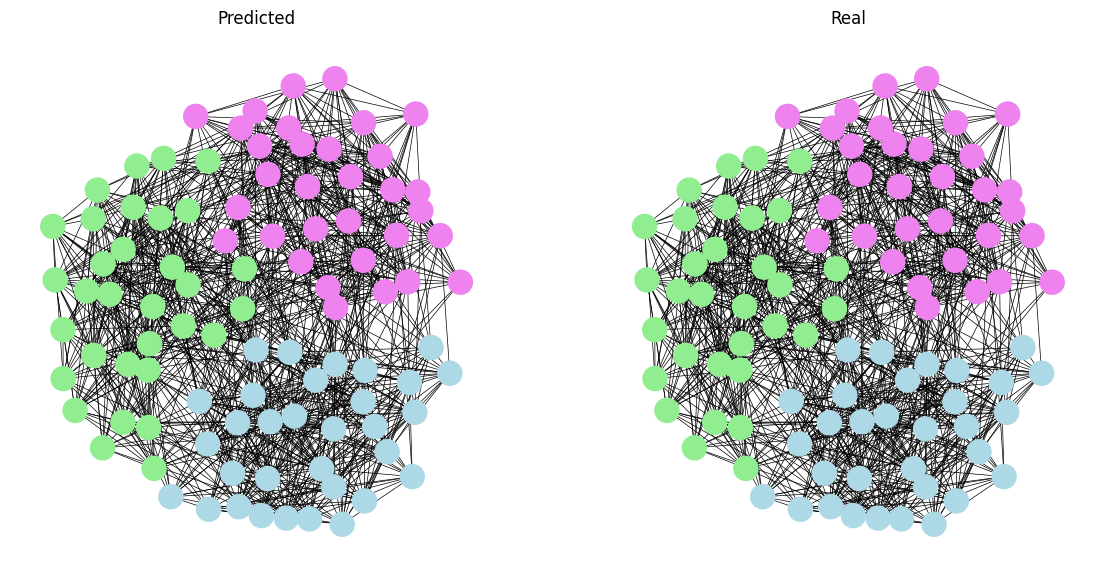

In [70]:
plt.figure(figsize = (14, 7))

plt.subplot(1, 2, 1)
node_color = [colors[v] for v in model.predict(G, G.nodes)]
nx.draw_kamada_kawai(G, node_color = node_color, width = .5)
plt.title("Predicted")
plt.subplot(1, 2, 2)
node_color = [colors[v] for v in y]
nx.draw_kamada_kawai(G, node_color = node_color, width = .5)
plt.title("Real")

### Real network

In [71]:
from utils.utils import walk_graph
from gensim.models.word2vec import Word2Vec
from sklearn.linear_model import LogisticRegression

In [72]:
name = "twitch" #  "wikipedia"
G = GraphReader(name).get_graph()
X = GraphReader(name).get_features()
y = GraphReader(name).get_target()

print(G)
print(np.unique(y, return_counts=True))

Graph with 7126 nodes and 35324 edges
(array([0, 1]), array([3238, 3888]))


In [73]:
start_node = 0
walk_length = 20
walks_per_node = 10
print(start_node)

0


In [74]:
walks = walk_graph(
    G, walks_per_node=walks_per_node, walk_length=walk_length
)
print(G.number_of_nodes(), len(walks))

7126 71260


In [75]:
# Transform entries into strings, since they must be "words" for word2vec to work.
for i in range(len(walks)):
    for j in range(walk_length):
        walks[i][j] = str(walks[i][j])

In [76]:
w2v = Word2Vec(sentences=walks, vector_size=4, epochs=10)
X = np.array([w2v.wv[str(n)] for n in G])
X.shape

(7126, 4)

In [77]:
# X = StandardScaler().fit_transform(X)

In [78]:
np.unique(y, return_counts=True)

(array([0, 1]), array([3238, 3888]))

In [79]:
X_train, X_test, y_train, y_test, nodes_train, nodes_test = train_test_split(X, y, list(G.nodes), test_size=.2, random_state=42)

In [80]:
phi1 = LogisticRegression()
phi2 = LogisticRegression()
model = IterativeClassifier(phi1=phi1, phi2=phi2)
model.fit(G, nodes_train, nodes_test, X, y_train, steps = 2)

In [81]:
y_train

array([0, 1, 0, ..., 1, 1, 1])

In [82]:
accuracy_score(y_train, model.predict(G, nodes_train))

1.0

In [83]:
np.unique(model.predict(G, nodes_test), return_counts = True)

(array([0, 1]), array([  20, 1406]))

In [84]:
accuracy_score(y_test, model.predict(G, nodes_test))

0.5336605890603086

In [85]:
model2 = LogisticRegression()
model2.fit(X_train, y_train)
accuracy_score(y_test, model2.predict(X_test))

0.532258064516129

## Belief propagation / Message passing
- [Wikipedia entry](https://en.wikipedia.org/wiki/Belief_propagation)
- [paper](https://arxiv.org/ftp/arxiv/papers/1301/1301.6725.pdf)

*Intuition*:
- Nodes "talk" about their label to each other by sending messages 
- message = node $u$ is sure $v$ is of class $Y_v$ with some probability
- Because we assumed that similar nodes cluster together we hope to converge somewhere and classify the nodes


Algorithm:
Suppose we are in node $i$
1. Node $i$ gets messages from the incoming neighbours $(u, v, k)$
2. Node $i$ computes his new message using his information and the incoming information 
3. Node $i$ passes his message formard to the next node $j$

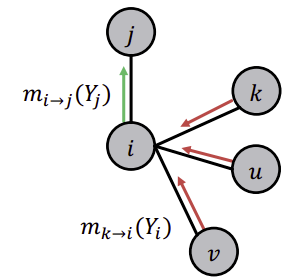

**Example: Node counting**

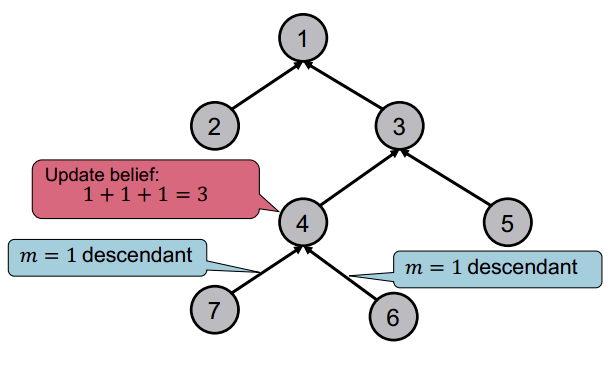

**What about cycles?**  
If we don't have cycles we can order a nodes in an advantageous way (Ex: trees start from bottom up). When cycles appear we can't do that anymore. Therefore we start for arbitrary nodes. We can still run the algorithm but messages will not be independent (they will come back in loops). Therefore we can just run a small number of iterations


**Pros**
- Easy to code and parallelize
- Can apply to any graph model

**Cons**
- Convergence not guaranteed
- Loops might make the process hard -> Only use a small number of iterations

**Is this useful?**
- Real world graphs tend to have branches (look like trees) or have long cycles. Therefore this is a good heuristic